# Testing Flood Detection

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from pathlib import Path
from shapely import box
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from flood_finder.floodprocessor import FloodProcessor
from flood_finder.reporter import ProcessorReporter
from flood_finder.waterfinder import WaterFinder
from flood_finder.imagery import ImageFinder
from owslib.wms import WebMapService


## Define the ROI

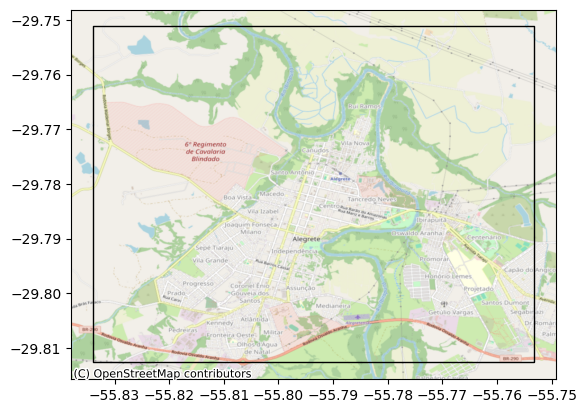

In [3]:
# Anavilhanas area
bbox = (-55.833918389468636,  -29.81268477102558, -55.75315601911373,  -29.75118793843714)

gdf = gpd.GeoDataFrame(geometry=[box(*bbox)])
ax = gdf.plot(facecolor='none')
cx.add_basemap(ax=ax, crs='epsg:4326', source=cx.providers.OpenStreetMap.Mapnik)

## Create a `FloodProcessor` instance

In [5]:
# read the subscription key
with open('../subscription.key', 'r') as file:
    subscription_key = file.read()

In [16]:
# clear the ../tmp folder
for item in Path('../tmp').iterdir():
    item.unlink(missing_ok=True)

processor = FloodProcessor(
    aoi_df=gpd.GeoDataFrame(geometry=[box(*bbox)]),
    output_dir='../tmp',
    time_range='2019-01-01/2019-01-31',
    subscription_key=subscription_key,
    lee_size=None,
)

In [17]:
processor

Flood Processor for place: tmp
Variables: ['aoi_df', 'recurrence']
WaterFinder for place tmp
Available dates: 4
Water detected dates: 0

In [18]:
processor['recurrence'].shape

(247, 324)

In [19]:
processor.finder.s1imagery['2019-01-06']

<xarray.DataArray 'stackstac-265e8d5afc653b4eada1e56d2ed0ebb3' (band: 2,
                                                                y: 247, x: 324)>
array([[[0.01240111, 0.00604155, 0.01922798, ..., 0.0166038 ,
         0.01799127, 0.00991056],
        [0.0183301 , 0.01526277, 0.02741115, ..., 0.01164369,
         0.03016092, 0.01213252],
        [0.01191534, 0.01397895, 0.01149735, ..., 0.00915991,
         0.01685569, 0.01356332],
        ...,
        [0.07663105, 0.04606934, 0.01884126, ..., 0.01647308,
         0.02333891, 0.05602841],
        [0.01621878, 0.01913409, 0.01786021, ..., 0.04999812,
         0.01963066, 0.06323832],
        [0.03370049, 0.02297288, 0.01328537, ..., 0.03275777,
         0.05330373, 0.02608947]],

       [[0.03955576, 0.02259901, 0.09059462, ..., 0.03814093,
         0.03749226, 0.04759597],
        [0.03698715, 0.03913178, 0.08383612, ..., 0.15763034,
         0.02575381, 0.05104584],
        [0.05020091, 0.0503865 , 0.03008874, ..., 0.0526115 ,
         0.02525613, 0.05221704],
        ...,
        [0.06402735, 0.15743224, 0.06473029, ..., 0.17772059,
         0.27680847, 0.17028649],
        [0.07139309, 0.04566155, 0.05706139, ..., 0.09416086,
         0.21648723, 0.17587918],
        [0.01279461, 0.04661954, 0.05496437, ..., 0.06249882,
         0.10507229, 0.08035744]]], dtype=float32)
Coordinates: (12/40)
  * x                                      (x) float64 -55.83 -55.83 ... -55.75
  * y                                      (y) float64 -29.75 -29.75 ... -29.81
    sat:orbit_state                        <U10 'descending'
    sar:instrument_mode                    <U2 'IW'
    s1:resolution                          <U4 'high'
    sar:center_frequency                   float64 5.405
    ...                                     ...
    sar:resolution_range                   int64 20
    sar:observation_direction              <U5 'right'
    proj:bbox                              object {6633370.0, 454740.0, 68700...
    sat:absolute_orbit                     int64 14371
    s1:product_timeliness                  <U8 'Fast-24h'
    spatial_ref                            int64 0
Attributes:
    _FillValue:  3.402823466e+38

In [20]:
processor.find_water('../model/RF_Model_v2.joblib', use_gfm=False, resume=False)

  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
processor.process_floods()

  0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
processor

Flood Processor for place: tmp
Variables: ['aoi_df', 'recurrence', 'waters', 'water_series', 'data_table', 'floods', 'max_flood']
WaterFinder for place tmp
Available dates: 4
Water detected dates: 4

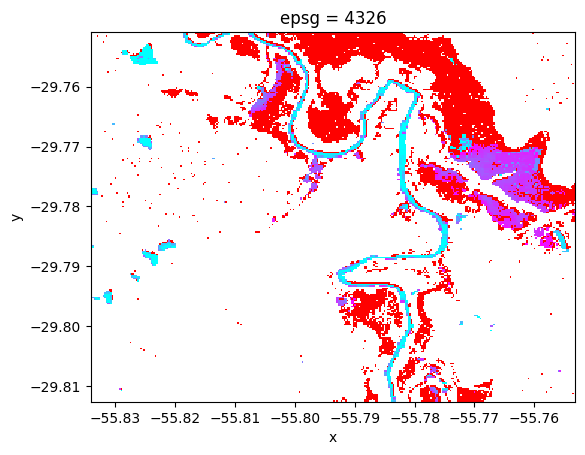

In [29]:
fig, ax = plt.subplots()
processor.plot_vars(ax=ax)

<Axes: title={'center': 'Flood for 2019-01-18'}, xlabel='x', ylabel='y'>

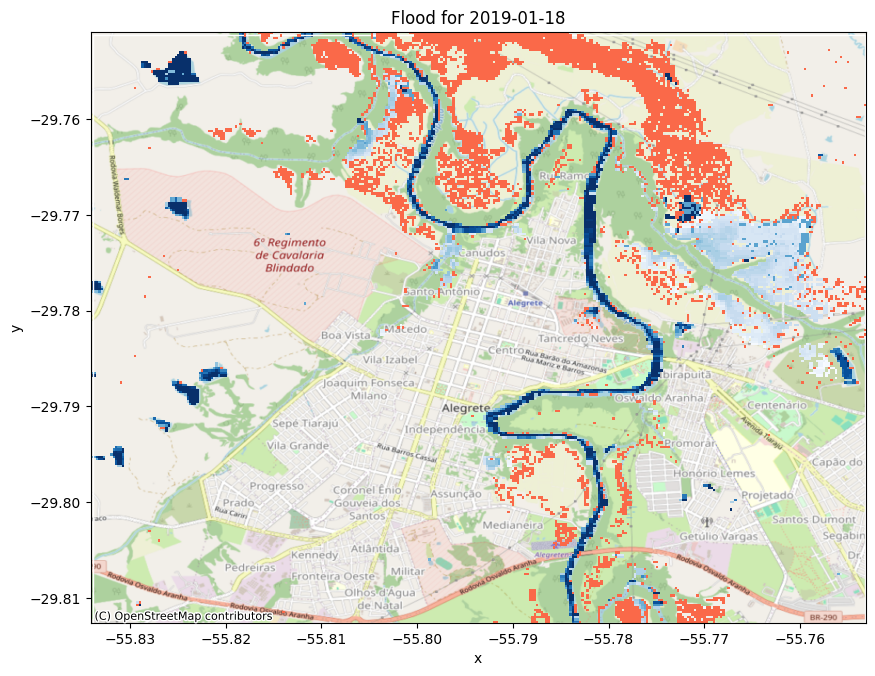

In [31]:
processor.plot_flood('2019-01-18')

## GFM Tests

Now, let's use GFM to deliver the same masks

In [32]:
processor.find_water(use_gfm=True, resume=False)

  0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
processor.process_floods()

  0%|          | 0/3 [00:00<?, ?it/s]

<Axes: title={'center': 'Flood for 2019-01-18'}, xlabel='x', ylabel='y'>

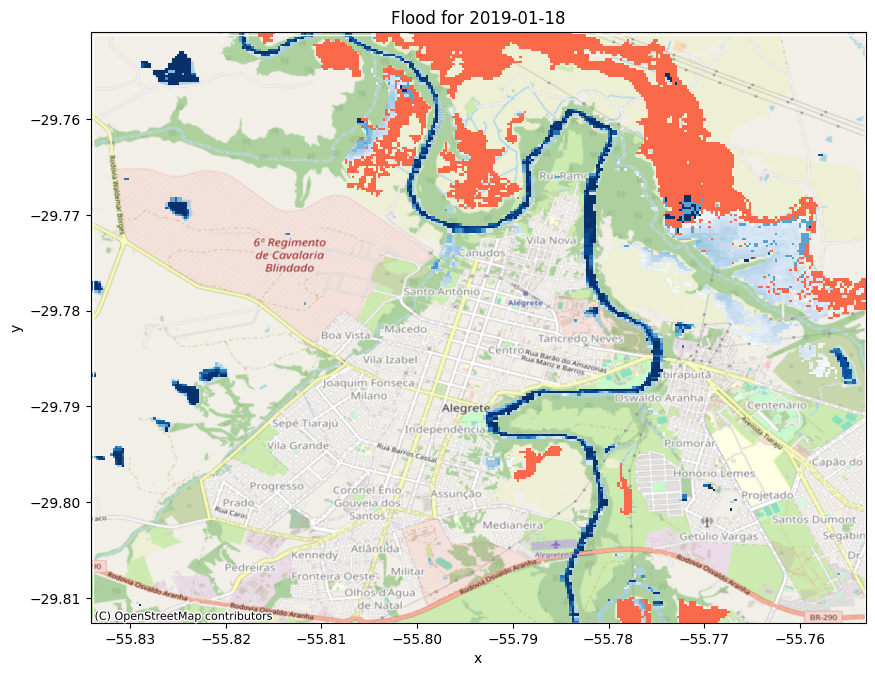

In [34]:
processor.plot_flood('2019-01-18')

In [123]:
processor['data_table']

,Water Extents,Flood area
2019-01-06,0.0000,0.0000
2019-01-18,39.5631,4.7475
2019-01-30,0.0000,0.0000
2019-02-11,7.0452,0.7200
2019-02-23,7.8795,0.8244
